Connect X - Deep Value Network
==============================

The biggest inspiration was [REINFORCEMENT LEARNING (DQN) TUTORIAL by Adam Paszke and Mark Towers](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html).

The Model weights were always downloaded from the previous saved version and uploaded. 


In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed). 
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip install 'kaggle-environments>=0.1.6'

In [10]:
#__main__.py
import torch
import torch.nn as nn
import torch.nn.functional as F

WEIGHTS_PATH = '/kaggle/input/connectxw/target_net_6_7_4.pth'
ROWS = 6
COLS = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, 128)
        self.layer6 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)

    
agent_net = DQN(ROWS*COLS+1, COLS).to(device)
agent_net.load_state_dict(
    torch.load(WEIGHTS_PATH, map_location=torch.device(device)))

def state_from_obs(obs):
    return [*obs['board'], obs['mark']]

def get_valid_actions(states, n_actions: int=COLS, EMPTY=0) -> list:
    return [col for col in range(n_actions) if states[:, col] == EMPTY]

def agent(obs, config):
    state = state_from_obs(obs)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    valid = get_valid_actions(state)
    with torch.no_grad():
        action = valid[agent_net(state).squeeze()[valid].argmax().item()]
    return action

In [11]:
import kaggle_environments
env = kaggle_environments.make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

Success!


In [12]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import itertools
from itertools import count

import numpy as np

import kaggle_environments
from kaggle_environments import evaluate, utils

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [13]:
%matplotlib inline

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion() # Enables interactive mode.

In [14]:
BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # GAMMA is the discount factor as mentioned in the previous section

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


def select_action(state, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[
            random.choice(get_valid_actions(state))
        ]], device=device, dtype=torch.long)

def optimize_model(batch_size=BATCH_SIZE, gamma=GAMMA):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(
            map(lambda s: s is not None, batch.next_state)
                                       ), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(dim=1, index=action_batch)
    # state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping ??? TODO
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


def plot_rewards(rewards: list, mean_rewards: list,
                 epsilons: list, show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.plot(np.array(rewards), '.', label='reward')
    plt.plot(np.array(mean_rewards, dtype=float), label='reward avg. 100')
    plt.plot(np.array(epsilons), label='epsilon')
    best_avg = max(mean_rewards[100:]) if mean_rewards[100:] else np.nan
    print(f'Avg. reward: {mean_rewards[-1]:.4}'
          f', best avg {best_avg:.4}'
          f', epsilon: {epsilons[-1]:.4}'
    )
    plt.legend()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [15]:
WEIGHTS_PATH = '/kaggle/input/connectxw/target_net_6_7_4.pth'
LR = 1e-4 # LR is the learning rate of the AdamW optimizer
CONFIG = {"rows": ROWS, "columns": COLS, "inarow": 4}
env = kaggle_environments.make('connectx',
                               configuration=CONFIG,
                               debug=True)
trainer = env.train([None, 'random'])
n_actions = env.configuration.columns
obs = trainer.reset()
state = state_from_obs(obs)
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(
    torch.load(WEIGHTS_PATH, map_location=torch.device(device)))

target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [16]:
agents = ['random', 'negamax']
agents_evaluation = [
    *itertools.product([agent], agents),
    *itertools.product(agents, [agent])
]

for agents in agents_evaluation:
    rewards = kaggle_environments.evaluate(
        "connectx", agents, CONFIG, num_episodes=10)
    print(dict(zip(agents, (np.array(rewards) == 1).mean(axis=0))))

{<function agent at 0x7f7f48c69170>: 0.5, 'random': 0.5}
{<function agent at 0x7f7f48c69170>: 0.1, 'negamax': 0.9}
{'random': 0.5, <function agent at 0x7f7f48c69170>: 0.5}
{'negamax': 1.0, <function agent at 0x7f7f48c69170>: 0.0}


In [17]:
oponents = ['random', agent, 'negamax']
agent_combinations = [
    *itertools.product([None], oponents),
    *itertools.product(oponents, [None])
]

yield_agents = itertools.cycle(agent_combinations)

for i in range(10):
    print(next(yield_agents))

(None, 'random')
(None, <function agent at 0x7f7f48c69170>)
(None, 'negamax')
('random', None)
(<function agent at 0x7f7f48c69170>, None)
('negamax', None)
(None, 'random')
(None, <function agent at 0x7f7f48c69170>)
(None, 'negamax')
('random', None)


Complete
Avg. reward: -0.06, best avg 0.2, epsilon: 0.05573


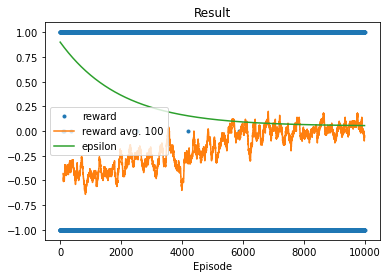

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
EPS_START = 0.9 # EPS_START is the starting value of epsilon
EPS_END = 0.05 # EPS_END is the final value of epsilon
EPS_DECAY = 0.0005 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # TAU is the update rate of the target network
ILLEGAL = -1
num_episodes = 10000

rewards = []
mean_rewards = []
epsilons = []
for i_episode in range(num_episodes):
    trainer = env.train(next(yield_agents))
    obs = trainer.reset()
    state = [*obs['board'], obs['mark']]
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    epsilon = (EPS_END 
        + (EPS_START - EPS_END)*math.exp(-1.*i_episode*EPS_DECAY))
    for t in count():
        action = select_action(state, epsilon=epsilon)
        obs, reward, done, _ = trainer.step(action.item())
        observation = [*obs['board'], obs['mark']]
        if reward is None:
            reward = ILLEGAL
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = (policy_net_state_dict[key]*TAU
                                          + target_net_state_dict[key]*(1-TAU))
        target_net.load_state_dict(target_net_state_dict)

        if done:
            rewards.append(reward.item())
            mean_rewards.append(np.mean(rewards[-100:])
                if len(rewards) >= 100 else np.nan)
            epsilons.append(epsilon)
            plot_rewards(rewards, mean_rewards, epsilons)
            break

print('Complete')
plot_rewards(rewards, mean_rewards, epsilons, show_result=True)
plt.ioff()
plt.show()

In [1]:
path = '/kaggle/working/target_net_6_7_4.pth'
torch.save(target_net.state_dict(), path)

NameError: name 'torch' is not defined